# Ford vs Ferrari

<img src="https://specials-images.forbesimg.com/imageserve/5de4fef2755ebf0006fbee0d/960x0.jpg?cropX1=0&cropX2=3670&cropY1=346&cropY2=2447">

# Загрузка данных и библиотек

In [18]:
import warnings
import torch
from os.path import exists
import numpy as np
from PIL import Image
from google.colab import drive
import pickle
from skimage import io
from tqdm import tqdm, tqdm_notebook
#import Image
from pathlib import Path
from torchvision import models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from matplotlib import colors, pyplot as plt
%matplotlib inline

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [19]:
# проверка на подключение colab к gpu
cuda_output = !ldconfig - p | grep cudart.so | sed - e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [20]:
# локальное подключение Google диска, на который загружены картинки
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [21]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [22]:
# пути на гугл диск, соответственно для тренировочной и тестовой выборки
TRAIN_DIR = Path('gdrive/MyDrive/FordAndFerrari/train')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

TEST_DIR = Path('gdrive/MyDrive/FordAndFerrari/test_upload')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

В следующем классе мы преобразуем картинки, соответственно нормализуем и переводим в тензоры. Здесь была использована аугментация:
<ul>
<li><code>RandomRotation(degrees=30)</code> - с вероятностью 0.5, картинка будет перевернута на 30 градусов;</li>
<li><code>RandomHorizontalFlip()</code> - с вероятностью 0.5, картинка будет зеркально отображена по горизонтали.
    </li>
    </ul>

In [23]:
class CarDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                #transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [24]:
# функция для рисования картинок
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [25]:
# разбиваем выборки на тестовую и валидационную
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(
    train_val_files, test_size=0.25, stratify=train_val_labels)

In [26]:
val_dataset = CarDataset(val_files, mode='val')
train_dataset = CarDataset(train_files, mode='train')
test_dataset = CarDataset(test_files, mode='test')

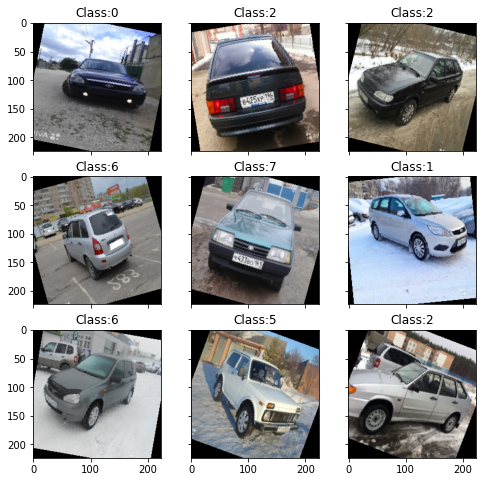

In [27]:
# Посмотрим на картинки
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10000))
    im_val, label = train_dataset[random_characters]
    img_label ='Class:' + str(train_dataset.label_encoder.inverse_transform([label])[0])
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Обучение модели

In [28]:
# функция вызывающаяся каждую эпоху, для обучения по батчам на тренировочной выборке, возвращает среднее значение функции
# потерь и accuracy


def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [29]:
# функция вызывающаяся каждую эпоху, для предсказания на валидационной выборке, возвращает среднее значение функции
# потерь и accuracy


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    #criterion = nn.CrossEntropyLoss()
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [30]:
# основная функция для обучения модели
def train(train_files, val_files, model, epochs, batch_size, optimizer):
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(
                model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [31]:
# функция для предсказания на тестовой выборке
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

В качестве нейронной сети выбранная предобученная сеть ResNet 101, выбран вариант с разморозкой всех слоев. В качестве оптимизирующей функции взята SGD.

In [32]:
torch.cuda.empty_cache()
n_classes = len(np.unique(train_val_labels))
resnet_101 = models.resnet101(pretrained=True).to(DEVICE)

#Блок для замораживания всех слоев предобученной сети
#for param in resnet_18.parameters():
#    param.requires_grad = False

num_ftrs = resnet_101.fc.in_features
resnet_101.fc = nn.Linear(num_ftrs, n_classes)
resnet_101 = resnet_101.to(DEVICE)
#optimizer_ft = torch.optim.AdamW(resnet_18.parameters(), lr=0.001)
optimizer_ft = torch.optim.SGD(resnet_101.parameters(), lr=0.001, momentum=0.90)
print("we will classify :{}".format(n_classes))

we will classify :10


In [33]:
import torchsummary
print(torchsummary.summary(resnet_101.cuda(), (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [34]:
history = train(train_dataset, val_dataset, model=resnet_101, epochs=13, batch_size=100, optimizer=optimizer_ft)

epoch:   0%|          | 0/13 [00:00<?, ?it/s]

loss 1.8210161095924018


epoch:   8%|▊         | 1/13 [05:34<1:06:57, 334.77s/it]


Epoch 001 train_loss: 1.8210     val_loss 1.0766 train_acc 0.3883 val_acc 0.6464
loss 0.7098158120393957


epoch:  15%|█▌        | 2/13 [11:02<1:00:57, 332.54s/it]


Epoch 002 train_loss: 0.7098     val_loss 0.3536 train_acc 0.7375 val_acc 0.8728
loss 0.3753862201707835


epoch:  23%|██▎       | 3/13 [16:29<55:09, 330.99s/it]


Epoch 003 train_loss: 0.3754     val_loss 0.3821 train_acc 0.8673 val_acc 0.8759
loss 0.23253720485459256


epoch:  31%|███       | 4/13 [21:57<49:31, 330.16s/it]


Epoch 004 train_loss: 0.2325     val_loss 0.2818 train_acc 0.9153 val_acc 0.9106
loss 0.18394733242684178


epoch:  38%|███▊      | 5/13 [27:25<43:54, 329.30s/it]


Epoch 005 train_loss: 0.1839     val_loss 0.2330 train_acc 0.9338 val_acc 0.9208
loss 0.15979605613096004


epoch:  46%|████▌     | 6/13 [32:52<38:21, 328.78s/it]


Epoch 006 train_loss: 0.1598     val_loss 0.2563 train_acc 0.9436 val_acc 0.9162
loss 0.12663748250650153


epoch:  54%|█████▍    | 7/13 [38:19<32:49, 328.28s/it]


Epoch 007 train_loss: 0.1266     val_loss 0.2103 train_acc 0.9552 val_acc 0.9316
loss 0.1104793991564734


epoch:  62%|██████▏   | 8/13 [43:46<27:19, 327.93s/it]


Epoch 008 train_loss: 0.1105     val_loss 0.2125 train_acc 0.9606 val_acc 0.9319
loss 0.10523947735014591


epoch:  69%|██████▉   | 9/13 [49:14<21:51, 327.89s/it]


Epoch 009 train_loss: 0.1052     val_loss 0.2207 train_acc 0.9612 val_acc 0.9332
loss 0.09309927695099625


epoch:  77%|███████▋  | 10/13 [54:41<16:22, 327.48s/it]


Epoch 010 train_loss: 0.0931     val_loss 0.2203 train_acc 0.9661 val_acc 0.9337
loss 0.08333089886410378


epoch:  85%|████████▍ | 11/13 [1:00:07<10:54, 327.27s/it]


Epoch 011 train_loss: 0.0833     val_loss 0.2226 train_acc 0.9704 val_acc 0.9319
loss 0.08124295213509546


epoch:  92%|█████████▏| 12/13 [1:05:34<05:27, 327.20s/it]


Epoch 012 train_loss: 0.0812     val_loss 0.2162 train_acc 0.9716 val_acc 0.9363
loss 0.07120524896843472


epoch: 100%|██████████| 13/13 [1:11:01<00:00, 327.81s/it]


Epoch 013 train_loss: 0.0712     val_loss 0.2124 train_acc 0.9746 val_acc 0.9383


Строим кривые обучения

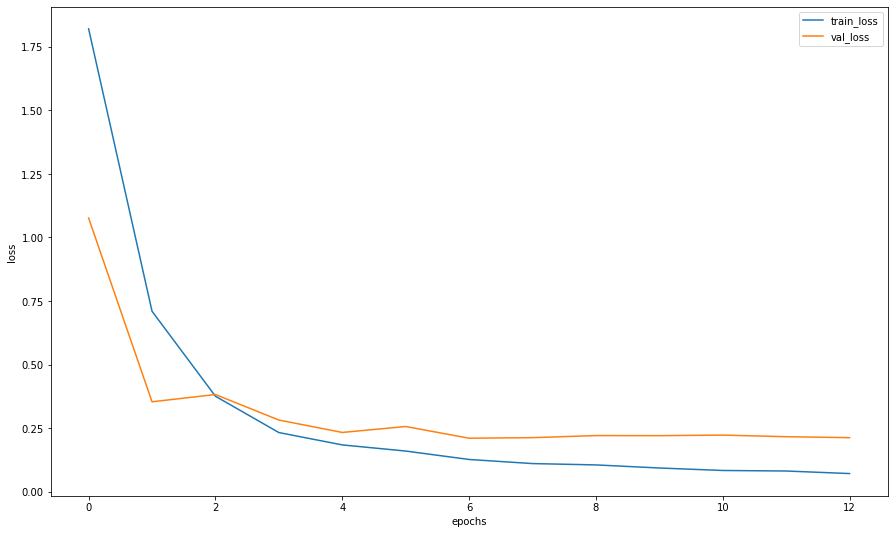

In [35]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Посмотрим на предсказанные значения для валидационной выборки.

In [36]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [37]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet_101, ex_img.unsqueeze(0))

In [38]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet_101, imgs)

In [39]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [40]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [41]:
# посмотрим на метрику f1
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred.tolist(), average='micro')

1.0

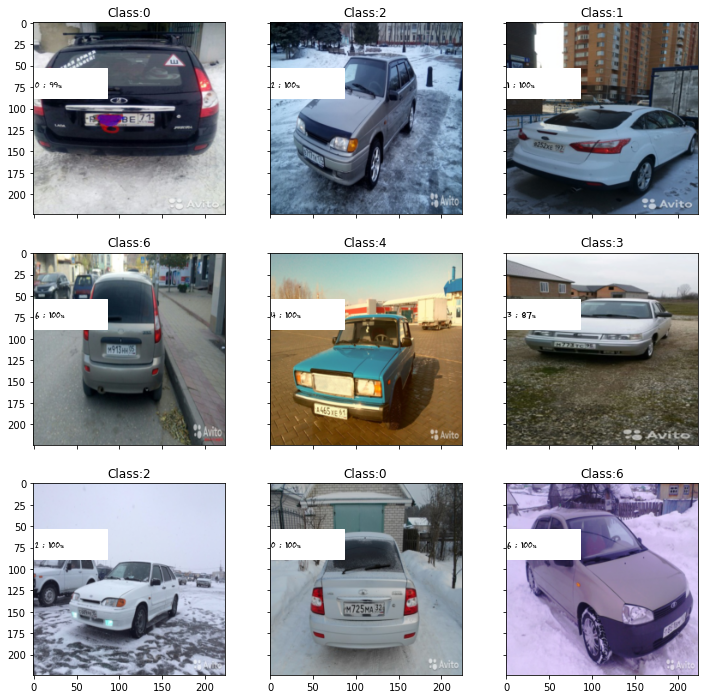

In [42]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,3000))
    im_val, label = val_dataset[random_characters]
    img_label ='Class:'+ " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet_101, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Prediction

In [43]:
# предсказываем значения для тестовой выборки
test_dataset = CarDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet_101, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [44]:
import pandas as pd
sabmit = pd.read_csv("gdrive/MyDrive/FordAndFerrari/sample-submission.csv")
my_submit = pd.DataFrame({'Id':test_filenames, 'Category':preds}, columns=['Id', 'Category'])
my_submit.head()

,Id,Category
0,293307.jpg,3
1,293359.jpg,3
2,293370.jpg,3
3,293435.jpg,3
4,293520.jpg,3


In [ ]:
# финальный сабмит
my_submit.to_csv('my_submission.csv',index=False)